# Часть 1. Проверка гипотезы в Python и составление аналитической записки

- Автор: Кознов Алексей
- Дата: 30.05.2025

## Цели и задачи проекта

Проверить гипотезу о том, что пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы.

Задачи:
1. Загрузить данные и познакомиться с их содержимым.
2. Провести предобработку данных.
3. Проверить гипотезу.
4. Сформулировать выводы по полученным результатам.

## Описание данных

Мы имеем таблицу с данными о количестве часов и активности пользователей из Москвы и Санкт-Петербурга `yandex_knigi_data.csv`

В датасете представлены столбцы:
- `city` - город пользователя
- `puid` - идентификатор пользователя
- `hours` - количество часов чтения книг

## Содержимое проекта

1. Загрузка данных и знакомство с ними
2. Предобработка
3. Исследовательский анализ
2. Проверка гипотезы в Python
3. Аналитическая записка

---

## 1. Загрузка данных и знакомство с ними

In [7]:
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportions_ztest

In [8]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/yandex_knigi_data.csv')

In [9]:
df.head()

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


## 2. Предобработка

Удалим столбец `Unnamed: 0`, т.к. он просто дублирует индексы датафрейма и не нужен для работы.

Остальные столбцы имеют корректные типы данных и не имеют пропусков, оставим их без изменения.

In [13]:
df = df.drop('Unnamed: 0', axis=1)

In [14]:
df.head()

,city,puid,hours
0,Москва,9668,26.167776
1,Москва,16598,82.111217
2,Москва,80401,4.656906
3,Москва,140205,1.840556
4,Москва,248755,151.326434


In [15]:
df.duplicated().sum()

0

Явных дубликатов не обнаружено

In [17]:
df.duplicated(subset='puid').sum()

244

In [18]:
df.duplicated(subset='puid').mean()

0.027777777777777776

Удалим дубликаты по столбцу `puid`

In [20]:
df = df.drop_duplicates(subset='puid')

In [21]:
df.duplicated(subset='puid').sum()

0

## 3. Исследовательский анализ

Сравним размеры групп, их статистики и распределение

In [24]:
df['city'].value_counts()

city
Москва             6234
Санкт-Петербург    2306
Name: count, dtype: int64

In [25]:
msk_users = df[df['city'] == 'Москва']
spb_users = df[df['city'] == 'Санкт-Петербург']

In [26]:
msk_users['hours'].describe()

count    6234.000000
mean       10.881092
std        36.851683
min         0.000018
25%         0.059903
50%         0.924498
75%         5.939972
max       857.209373
Name: hours, dtype: float64

Уберем слишком большие значения на графике

In [28]:
q2 = msk_users['hours'].quantile(0.95)

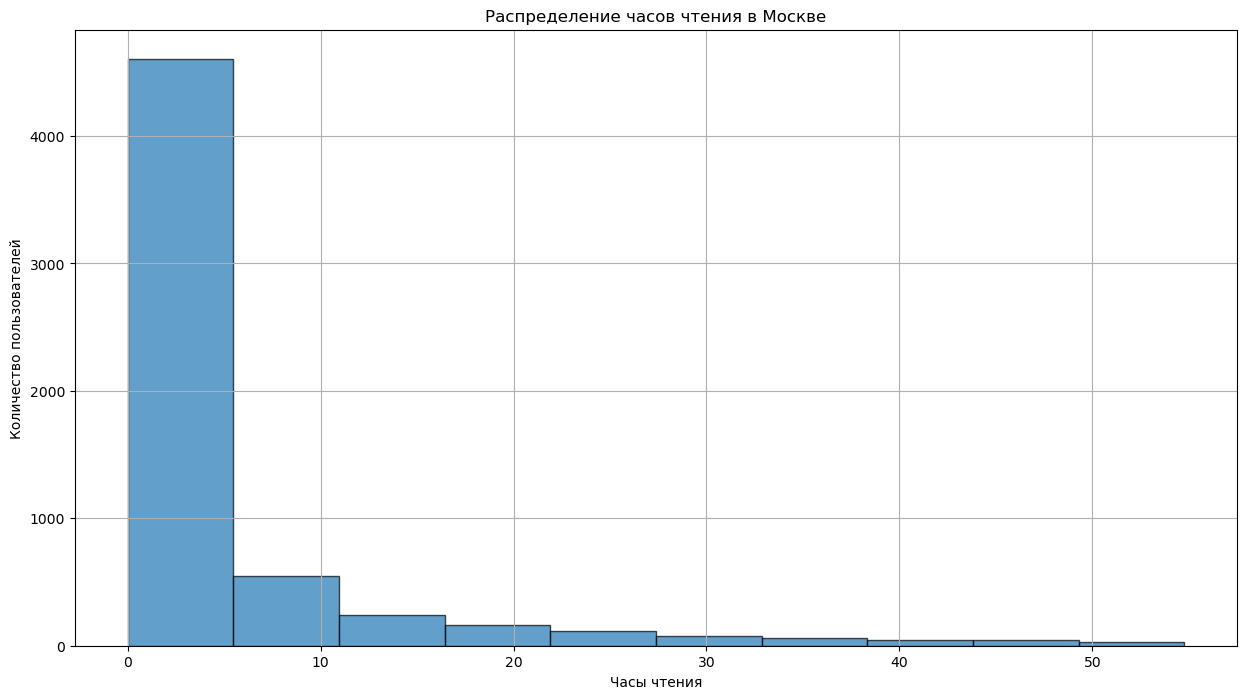

In [29]:
plt.figure(figsize=(15, 8))

msk_users[msk_users['hours'] < q2]['hours'].hist(edgecolor='black', alpha=0.7, grid=False)

plt.title('Распределение часов чтения в Москве') 
plt.xlabel('Часы чтения')
plt.ylabel('Количество пользователей')
plt.grid()
plt.show()

In [30]:
spb_users['hours'].describe()

count    2306.000000
mean       11.264433
std        39.831755
min         0.000025
25%         0.060173
50%         0.875355
75%         6.138424
max       978.764775
Name: hours, dtype: float64

In [31]:
q2 = spb_users['hours'].quantile(0.95)

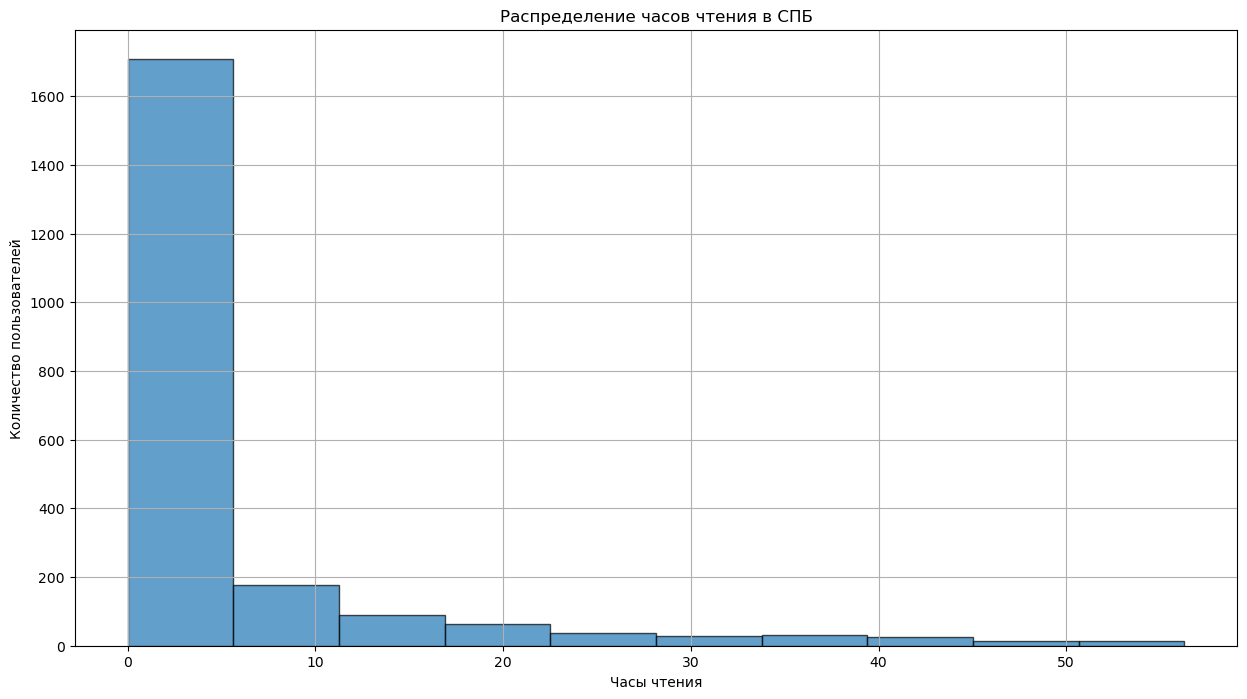

In [32]:
plt.figure(figsize=(15, 8))

spb_users[spb_users['hours'] < q2]['hours'].hist(edgecolor='black', alpha=0.7, grid=False)

plt.title('Распределение часов чтения в СПБ') 
plt.xlabel('Часы чтения')
plt.ylabel('Количество пользователей')
plt.grid()
plt.show()

Распределение на обоих графиках ассимитрично, скошенно вправо. 

В Москве медиана составляет чуть меньше часа (0.93) при среднем в 10.88 часов, большинство пользователей сосредоточены в значении от 0 до 5 часов чтения. 

В Санкт-Петербурге медиана составляет чуть меньше часа (0.99) при среднем в 11.6 часов, большинство пользователей также сосредоточены в значении от 0 до 5 часов чтения. 

И в той и другой группе имеются выбросы.

## 4. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуем статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

Т.к. распределение не нормальное, а также имеются выбросы, то используем тест Манна — Уитни

In [36]:
from scipy.stats import mannwhitneyu

alpha= 0.05

mw_test = mannwhitneyu(
    spb_users['hours'],
    msk_users['hours'], 
    alternative='greater')


if mw_test.pvalue > alpha:
    print(f'pvalue={mw_test.pvalue} > {alpha}')
    print('Нулевая гипотеза находит подтверждение! Распределения метрики в группах равны')
else:
    print(f'pvalue={mw_test.pvalue} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения! Распределения метрики в группах различаются')

pvalue=0.6189600878052618 > 0.05
Нулевая гипотеза находит подтверждение! Распределения метрики в группах равны


## 5. Аналитическая записка

Мы использовали тест Манна — Уитни и уровень значимости в 0.05. 

В результате мы получили значение p-value равное 0.61896. 

На основе полученного p-value мы не отклоняем нулевую гипотезу, которая звучит так: средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

На уровне значимости 5% нет статистически значимых различий в времени чтения между пользователями из Москвы и Санкт-Петербурга.

Хотя Петербург называют культурной столицей России, но это не влияет на пользователей и в Москве тоже есть достаточно большое число пользователей, которые слушают или читают книги в приложении. 

----

# Часть 2. Анализ результатов A/B-тестирования

## 1. Цели исследования.

Предыдущий аналитик проверял полное обновление дизайна сайта. Гипотеза заключается в следующем: упрощение интерфейса приведёт к тому, что в течение семи дней после регистрации в системе конверсия зарегистрированных пользователей в покупателей увеличится как минимум на три процентных пункта

Необходимо провести оценку результатов A/B-теста

Ключевая метрика: конверсия зарегистрированных пользователей в покупателей

## 2. Загрузим данные, оценим их целостность.


Данные таблицы `participants`
- `user_id` — идентификатор пользователя;
- `group` — группа пользователя;
- `ab_test` — название теста;
- `device` — устройство, с которого происходила регистрация.

Данные таблицы `events`
- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии.

In [46]:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

In [47]:
participants.head()

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


In [48]:
events.head()

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


In [49]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


In [50]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


In [51]:
participants.duplicated().sum()

0

In [52]:
events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       538264
dtype: int64

In [53]:
events.duplicated().sum()

36318

In [54]:
events = events.drop_duplicates()

In [55]:
events.duplicated().sum()

0

В датафрейме `participants` нет пропусков и дубликатов, формат столбцов тоже корректен.
В датафрейме `events` пропуски только в столбце `details`, оставим их без изменений. Также в датафрейме были дубликаты, мы их удалили.

## 3. По таблице `ab_test_participants` оценим корректность проведения теста:

In [58]:
test_users = participants[participants['ab_test'] == 'interface_eu_test']

test_users.head()

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
2,001064FEAAB631A1,A,interface_eu_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac
5,002412F1EB3F6E38,B,interface_eu_test,Mac
6,002540BE89C930FB,B,interface_eu_test,Android


Уникальные пользователи в группе A: 5383
Уникальные пользователи в группе B: 5467


Text(0.5, 1.0, 'Распределение пользователей по группам')

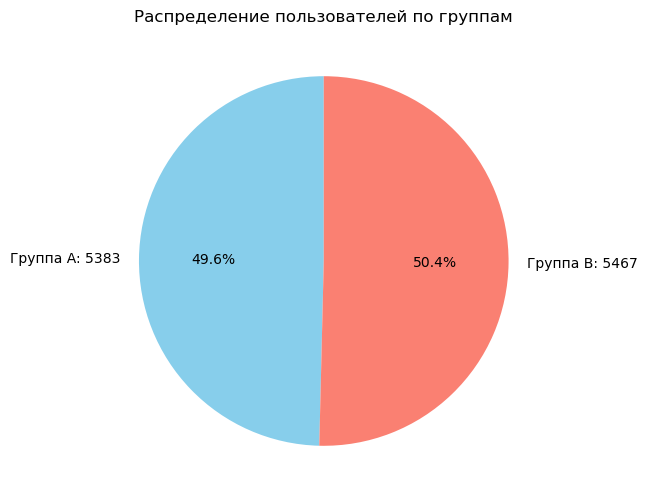

In [59]:
test_a = test_users[test_users['group'] == 'A']['user_id'].nunique()
test_b = test_users[test_users['group'] == 'B']['user_id'].nunique()

print(f"Уникальные пользователи в группе A: {test_a}")
print(f"Уникальные пользователи в группе B: {test_b}")

total_users = test_a + test_b

percent_a = round(100 * test_a / total_users, 1)
percent_b = round(100 * test_b / total_users, 1)

# Строим круговую диаграмму
plt.figure(figsize=(8, 6))
plt.pie([test_a, test_b],
        autopct='%1.1f%%',
        labels=[f'Группа A: {test_a}', 
                f'Группа B: {test_b}'],
        colors=['skyblue', 'salmon'],
        startangle=90)

plt.title(f'Распределение пользователей по группам')

Между группами существует небольшая разница в 0.8 процента. Разница статистически незначима, группы сбалансированы по объёму.

In [61]:
test_a = test_users[test_users['group'] == 'A']['user_id']
test_b = test_users[test_users['group'] == 'B']['user_id']

intersection = list(set(test_a) & set(test_b))

intersection = list(set(test_a) & set(test_b))
intersection

[]

In [62]:
test_interface = participants[participants['ab_test'] == 'interface_eu_test']['user_id']
test_recommender = participants[participants['ab_test'] == 'recommender_system_test']['user_id']


intersection = list(set(test_a) & set(test_b))

intersection = list(set(test_a) & set(test_b))
intersection

[]

Пересечений между группами одного теста и между тестами нет.

In [64]:
test_users[test_users['group'] == 'A']['device'].value_counts(normalize=True)

device
Android    0.454208
PC         0.250046
iPhone     0.190600
Mac        0.105146
Name: proportion, dtype: float64

In [65]:
test_users[test_users['group'] == 'B']['device'].value_counts(normalize=True)

device
Android    0.441558
PC         0.259374
iPhone     0.197732
Mac        0.101335
Name: proportion, dtype: float64

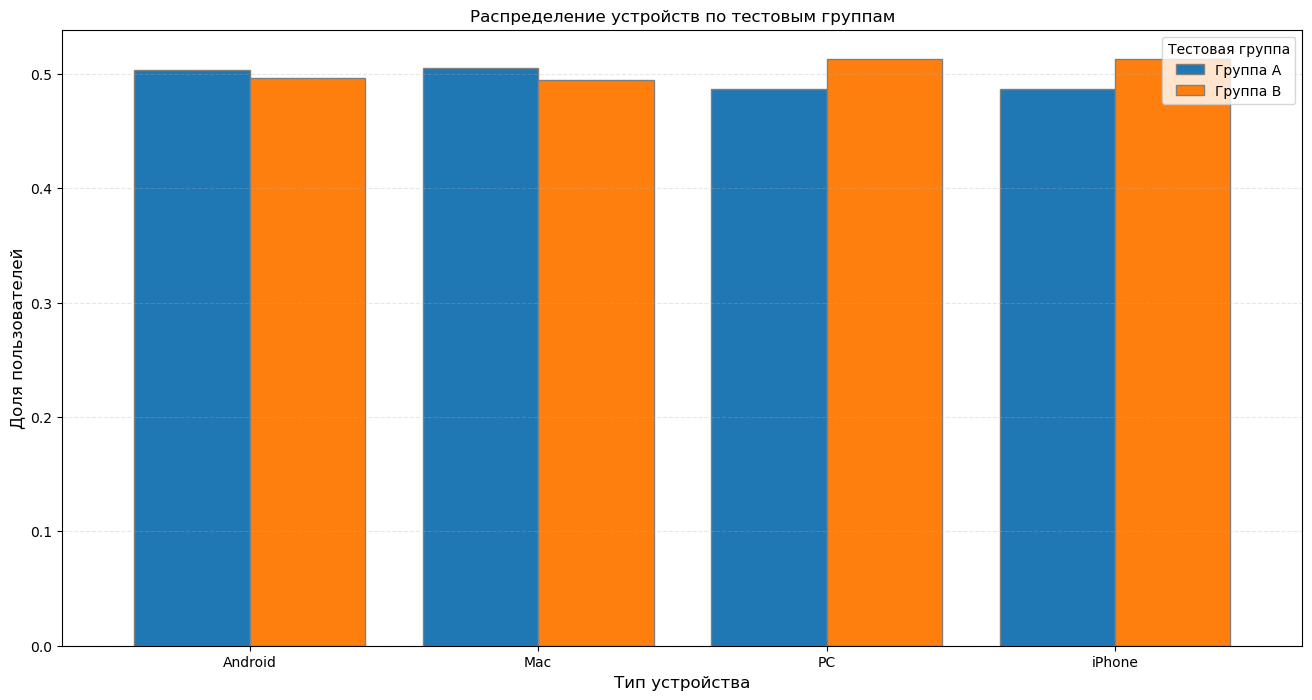

In [66]:
users_devices = test_users.drop_duplicates(['user_id', 'device'])

fig, ax = plt.subplots(figsize=(16, 8))
df_unstack = test_users.groupby('device')['group'].value_counts(normalize=True).unstack(fill_value=0)

df_unstack.plot(kind='bar', width=0.8, edgecolor='grey', ax=ax) 

plt.title('Распределение устройств по тестовым группам')
plt.xlabel('Тип устройства', fontsize=12)
plt.ylabel('Доля пользователей', fontsize=12)
plt.xticks(rotation=0) 
plt.grid(axis='y', linestyle='--', alpha=0.3) 
plt.legend(title='Тестовая группа', labels=['Группа A', 'Группа B'])

plt.show()

По устройствам тоже есть небольшое расхождение, но оно небольшое и им можно пренебречь

3\.2 Проанализируем данные о пользовательской активности по таблице `ab_test_events`:

In [69]:
test_ids = test_users['user_id']

In [70]:
test_events = events[events['user_id'].isin(test_ids)]

test_events.head()

,user_id,event_dt,event_name,details
64672,5F506CEBEDC05D30,2020-12-06 14:10:01,registration,0.0
64946,51278A006E918D97,2020-12-06 14:37:25,registration,-3.8
66585,A0C1E8EFAD874D8B,2020-12-06 17:20:22,registration,-3.32
67873,275A8D6254ACF530,2020-12-06 19:36:54,registration,-0.48
67930,0B704EB2DC7FCA4B,2020-12-06 19:42:20,registration,0.0


In [71]:
# Добавляем группу теста к событиям
test_events = test_events.merge(
    test_users[['user_id', 'group', 'device']],
    on='user_id',
    how='left'
)

# Проверяем распределение событий по группам
print(test_events['group'].value_counts())

group
B    37904
A    35641
Name: count, dtype: int64


In [72]:
test_events.head()

,user_id,event_dt,event_name,details,group,device
0,5F506CEBEDC05D30,2020-12-06 14:10:01,registration,0.0,A,iPhone
1,51278A006E918D97,2020-12-06 14:37:25,registration,-3.8,A,Android
2,A0C1E8EFAD874D8B,2020-12-06 17:20:22,registration,-3.32,B,iPhone
3,275A8D6254ACF530,2020-12-06 19:36:54,registration,-0.48,A,iPhone
4,0B704EB2DC7FCA4B,2020-12-06 19:42:20,registration,0.0,B,PC


In [73]:
# Временной диапазон теста
min_date = test_events['event_dt'].min()
max_date = test_events['event_dt'].max()
print(f"Временной диапазон теста:\nОт {min_date} до {max_date}")

Временной диапазон теста:
От 2020-12-06 14:10:01 до 2020-12-30 18:34:08


In [74]:
# Находим время регистрации для каждого пользователя
registration_times = (
    test_events[test_events['event_name'] == 'registration']
    .groupby('user_id')['event_dt'].first()
    .reset_index()
    .rename(columns={'event_dt': 'registration_time'})
)

In [75]:
# Добавляем время регистрации к основному датафрейму событий
test_events_with_reg = test_events.merge(registration_times, on='user_id', how='left')

In [76]:
# Вычисляем разницу во времени между событием и регистрацией
test_events_with_reg['time_since_reg'] = test_events_with_reg['event_dt'] - test_events_with_reg['registration_time']

In [77]:
# Оставляем только события в первые 7 дней (включая день регистрации
test_events_7days = test_events_with_reg[
    (test_events_with_reg['time_since_reg'] <= pd.Timedelta(days=7)) &
    (test_events_with_reg['time_since_reg'] >= pd.Timedelta(days=0))
]

In [78]:
# Проверяем
print(f"Всего событий: {len(test_events_7days)}")
print(f"Событий в первые 7 дней: {len(test_events_7days)}")
print(f"Уникальных пользователей: {test_events_7days['user_id'].nunique()}")

Всего событий: 63449
Событий в первые 7 дней: 63449
Уникальных пользователей: 10850


In [79]:
# Задаём параметры
alpha = 0.05  
beta = 0.2  
power = 1 - beta  
mde = 0.03  

p1 = 0.3  
p2 = p1 + mde
effect_size = (p2 - p1) / np.sqrt((p1*(1-p1) + p2*(1-p2))/2)


# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 3759


У нас задействовано 10850 уникальных пользователей, этого количества хватит для корректного проведения теста.

In [81]:
# Общее количество пользователей в каждой группе
total_users_per_group = (
    test_users.groupby('group')['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id': 'total_users'})
)

total_users_per_group

,group,total_users
0,A,5383
1,B,5467


In [82]:
# Покупатели в первые 7 дней
purchasing_users = (
    test_events_7days[test_events_7days['event_name'] == 'purchase']
    .groupby('group')['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id': 'purchased_users'})
)

purchasing_users

,group,purchased_users
0,A,1480
1,B,1600


In [83]:
# Объединяем и считаем конверсию
conversion_data = total_users_per_group.merge(
    purchasing_users,
    on='group',
    how='left'
)

In [84]:
conversion_data['conversion_rate'] = (
    conversion_data['purchased_users'] / conversion_data['total_users'] * 100
)

conversion_data

,group,total_users,purchased_users,conversion_rate
0,A,5383,1480,27.493962
1,B,5467,1600,29.266508


Ожидалось, что новый дизайн увеличит конверсию минимум на 3 процентных пункта, а прирост составил 1.77%, проверим являестя ли разница статитически значимой

## 4. Проведем оценку результатов A/B-тестирования:

In [87]:
buyers = [conversion_data.loc[conversion_data['group'] == 'B', 'purchased_users'].values[0],
         conversion_data.loc[conversion_data['group'] == 'A', 'purchased_users'].values[0]]
total = [conversion_data.loc[conversion_data['group'] == 'B', 'total_users'].values[0],
        conversion_data.loc[conversion_data['group'] == 'A', 'total_users'].values[0]]

z_stat, p_value = proportions_ztest(buyers, total, alternative='larger')

print(f"Z-тест пропорций: p-value = {p_value}")
if p_value < 0.05:
    print("Вывод: Разница статистически значима (p < 0.05)")
else:
    print("Вывод: Разница не статистически значима (p ≥ 0.05)")

Z-тест пропорций: p-value = 0.020306993983065475
Вывод: Разница статистически значима (p < 0.05)


#### Выводы по результатам A/B-теста
 - было задействовано  10850 пользователей. В группах А и B было 5383 и 5467 пользователей соответственно, пересечений не было, распределение по устройствам и группам было сбалансированным
 - внедрение новой версии сайта повлияло на рост ключевой метрики (конверсия зарегистрированных пользователей в покупателей). Разница между тестовыми группами составила чуть более  1.77 процента
 - p-value = 0.02031, что говорит о том, что разница между группами статистически значима.

Учитывая полученные результаты, новый дизайн доказал эффективность. И хотя ожидалось, что конверсия увеличится как минимум на три процентных пункта, но небольшой прирост успешности сессий в 1.77% является статистически значимым улучшением, что способствует повышению продаж.